In [1]:
import thermalizer.models.misc as misc
import thermalizer.kolmogorov.simulate as simulate
import thermalizer.kolmogorov.performance as performance
import torch
import seaborn as sns


import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np

In [2]:
sims_cut=-1
steps_cut=5000

model_emu=misc.load_model("/scratch/cp3759/thermalizer_data/wandb_data/wandb/run-20240416_052452-12d2m6kr/files/model_weights.pt")
test_data=torch.load("/scratch/cp3759/thermalizer_data/kolmogorov/test_suite/all.pt")
print(test_data.shape)
test_data=test_data[:sims_cut,:steps_cut]
print(test_data.shape)

torch.Size([64, 10000, 64, 64])
torch.Size([63, 5000, 64, 64])


In [3]:
import thermalizer.kolmogorov.util as util
import kymatio
from kymatio.torch import Scattering2D
from torch import optim
import torch.nn.functional as F

class ThermalizeKolmogorovScattering():
    def __init__(self,test_suite,model_emu,thermalize_delay=100,thermalize_interval=5,thermalize_timesteps=1,thermalize_lr=10):
        self.test_suite=(test_suite/model_emu.config["field_std"])
        self.model_emu=model_emu
        self.scattering=Scattering2D(J=2, shape=(self.test_suite.shape[-1],self.test_suite.shape[-1]), max_order=2)
        self.thermalize_delay=thermalize_delay
        self.thermalize_interval=thermalize_interval
        self.thermalize_timesteps=thermalize_timesteps
        self.thermalize_lr=thermalize_lr

        ## Set up field tensors
        self.emu=torch.zeros(self.test_suite.shape)
        self.therm=torch.zeros(self.test_suite.shape)

        ## Ensure models are in eval
        self.model_emu.eval()
        
        if torch.cuda.is_available():
            self.device=torch.device('cuda')
            ## Put models on GPU
            self.model_emu=self.model_emu.to(self.device)
            self.scattering=self.scattering.cuda()
            ## Put tensors on GPU
            self.test_suite=self.test_suite.to(self.device)
            self.emu=self.emu.to(self.device)
            self.therm=self.therm.to(self.device)

        ## Set t=0 to be the same
        self.emu[:,0,:,:]=self.test_suite[:,0,:,:]
        self.therm[:,0,:,:]=self.test_suite[:,0,:,:]

        self._init_metrics()
        ## Hardcode scattering coeff target for Kolmogorov flow
        self.scattering_target=torch.tensor([0.0145, 0.0124, 0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125,
                                            0.0142, 0.0121, 0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119,
                                            0.0135, 0.0120, 0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113,
                                            0.0133, 0.0113, 0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119,
                                            0.0135, 0.0118, 0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121,
                                            0.0142, 0.0126, 0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126,
                                            0.0149, 0.0130, 0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126,
                                            0.0149],device=self.device)
        self.scattering_target=self.scattering_target.repeat(len(self.test_suite),1)

    def _init_metrics(self):
        self.mseloss=torch.nn.MSELoss(reduction="none")
        ## Set up metric tensors
        self.mse_auto=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])
        self.mse_emu=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])
        self.mse_therm=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1])

        self.autocorr=[]
        self.corr_emu=[]
        self.corr_therm=[]

        self.grid=util.fourierGrid(64)
        self.ke_true=torch.zeros(self.test_suite.shape[0],self.test_suite.shape[1],len(self.grid.k1d_plot))
        self.ke_emu=torch.zeros(self.ke_true.shape)
        self.ke_therm=torch.zeros(self.ke_true.shape)

        return

    def _scattering_therm(self,inp_field,steps,lr=10):
        """ Thermalize using scattering coefficients. Run steps of gradient
            descent on the emulator fields, to match wavelet coefficients of the
            true fields """
        inp_field=inp_field.contiguous().requires_grad_(requires_grad=True)
        optimizer = optim.Adam([inp_field], lr=10)
        for epoch in range(steps):
            optimizer.zero_grad()
            new_coefficients = self.scattering(inp_field)
            loss = F.mse_loss(input=torch.mean(new_coefficients[:,:,17:],axis=(-2,-1)).squeeze(),target=self.scattering_target)
            loss.backward()
            optimizer.step()
        return inp_field.squeeze().detach()
        
    def _evolve(self):
        for aa in tqdm(range(1,len(self.test_suite[1]))):
            with torch.no_grad():
                ## Step fields forward
                emu_unsq=self.emu[:,aa-1,:,:].unsqueeze(1)
                self.emu[:,aa,:,:]=(self.model_emu(emu_unsq)+emu_unsq).squeeze()
    
                therm_unsq=self.therm[:,aa-1,:,:].unsqueeze(1)
                self.therm[:,aa,:,:]=(self.model_emu(therm_unsq)+therm_unsq).squeeze()

            should_thermalize = (aa % self.thermalize_interval == 0) and (aa>self.thermalize_delay)
            if should_thermalize:
                thermed=self._scattering_therm(self.therm[:,aa,:,:].unsqueeze(1),self.thermalize_timesteps,self.thermalize_lr)
                self.therm[:,aa,:,:]=thermed

            ## MSE metrics
            loss=self.mseloss(therm_rollout.test_suite[:,0],therm_rollout.test_suite[:,aa])
            self.mse_auto[:,aa]=torch.mean(loss,dim=(1,2))
            loss=self.mseloss(therm_rollout.test_suite[:,aa],therm_rollout.emu[:,aa])
            self.mse_emu[:,aa]=torch.mean(loss,dim=(1,2))
            loss=self.mseloss(therm_rollout.test_suite[:,aa],therm_rollout.therm[:,aa])
            self.mse_therm[:,aa]=torch.mean(loss,dim=(1,2))

    def _KE_spectra(self):
        ## Move to cpu for KE spectra calculation
        self.test_suite=self.test_suite.to("cpu")
        self.emu=self.emu.to("cpu")
        self.therm=self.therm.to("cpu")
        for aa in tqdm(range(1,len(self.test_suite[1]))):
            for bb in range(0,len(self.test_suite[0])):
                _,ke=util.get_ke(self.test_suite[aa,bb],self.grid)
                self.ke_true[aa,bb]=torch.tensor(ke)
                _,ke=util.get_ke(self.emu[aa,bb],self.grid)
                self.ke_emu[aa,bb]=torch.tensor(ke)
                _,ke=util.get_ke(self.therm[aa,bb],self.grid)
                self.ke_therm[aa,bb]=torch.tensor(ke)
  
        ## Move to back to gpu
        self.test_suite=self.test_suite.to(self.device)
        self.emu=self.emu.to(self.device)
        self.therm=self.therm.to(self.device)

In [19]:
therm_rollout=ThermalizeKolmogorovScattering(test_data,model_emu,thermalize_delay=50,thermalize_interval=10,thermalize_timesteps=10,thermalize_lr=0.001)

In [20]:
therm_rollout._evolve()

100%|██████████| 4999/4999 [06:38<00:00, 12.53it/s]


Text(0.5, 0, '# of steps')

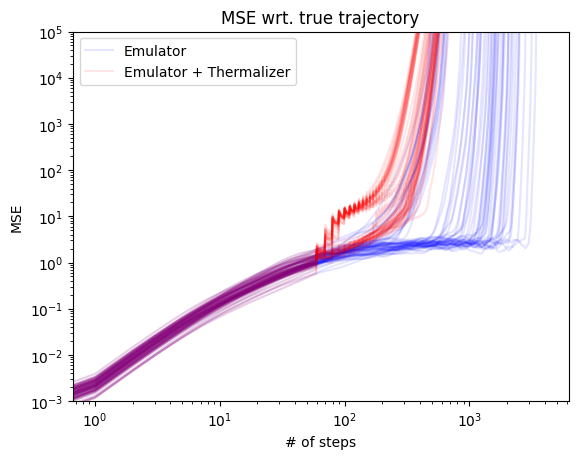

In [21]:
plt.title("MSE wrt. true trajectory")
plt.loglog(therm_rollout.mse_emu[0],color="blue",alpha=0.1,label="Emulator")
plt.loglog(therm_rollout.mse_therm[0],color="red",alpha=0.1,label="Emulator + Thermalizer")
for aa in range(1,len(therm_rollout.mse_auto)):
    #plt.loglog(therm_rollout.mse_auto[aa],color="gray",alpha=0.4)
    plt.loglog(therm_rollout.mse_emu[aa],color="blue",alpha=0.1)
    plt.loglog(therm_rollout.mse_therm[aa],color="red",alpha=0.1)
plt.ylim(1e-3,1e5)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("# of steps")

Text(0.5, 0, '# of steps')

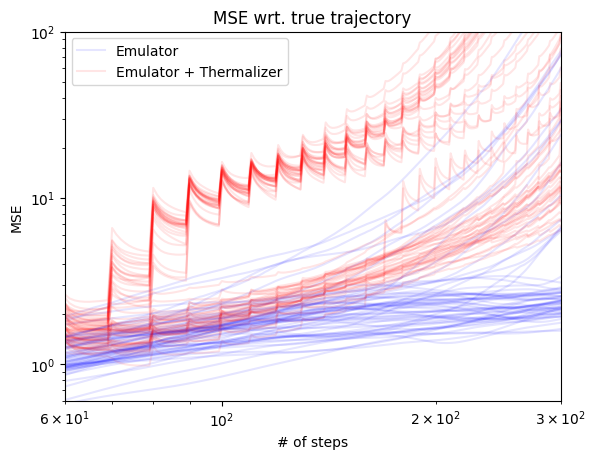

In [25]:
plt.title("MSE wrt. true trajectory")
plt.loglog(therm_rollout.mse_emu[0],color="blue",alpha=0.1,label="Emulator")
plt.loglog(therm_rollout.mse_therm[0],color="red",alpha=0.1,label="Emulator + Thermalizer")
for aa in range(1,len(therm_rollout.mse_auto)):
    #plt.loglog(therm_rollout.mse_auto[aa],color="gray",alpha=0.4)
    plt.loglog(therm_rollout.mse_emu[aa],color="blue",alpha=0.1)
    plt.loglog(therm_rollout.mse_therm[aa],color="red",alpha=0.1)
plt.ylim(6e-1,1e2)
plt.xlim(6e1,3e2)
plt.legend()
plt.ylabel("MSE")
plt.xlabel("# of steps")

In [ ]:
therm_rollout.scattering_target.shape

In [ ]:
torch.tensor([0.0145, 0.0124, 0.0093, 0.0079, 0.0074, 0.0076, 0.0094, 0.0130, 0.0125,
        0.0142, 0.0121, 0.0094, 0.0079, 0.0075, 0.0079, 0.0096, 0.0092, 0.0119,
        0.0135, 0.0120, 0.0089, 0.0074, 0.0073, 0.0079, 0.0077, 0.0086, 0.0113,
        0.0133, 0.0113, 0.0086, 0.0076, 0.0077, 0.0074, 0.0075, 0.0089, 0.0119,
        0.0135, 0.0118, 0.0091, 0.0079, 0.0080, 0.0075, 0.0079, 0.0093, 0.0121,
        0.0142, 0.0126, 0.0097, 0.0095, 0.0076, 0.0074, 0.0079, 0.0093, 0.0126,
        0.0149, 0.0130, 0.0124, 0.0091, 0.0077, 0.0076, 0.0077, 0.0092, 0.0126,
        0.0149])